## *One Class Classification (Outlier Detection)*
- <d>1. feature extractor ( AE [o] | VGG16 [_] | another )<d>
- <d>2. gaussian noise generator<d>
- <d>3. train_x = cat [ features, gaussian noise ]<d>
- <d>4. train_y = cat [ Y[features], Y[gaussian noise] ]<d>

In [258]:
from keras.models import Sequential,Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# keras Model.history 손실 출력
def plt_loss(history):
    fig, axs = plt.subplots(figsize=(15,15))

    axs.plot(history.history['loss'])
    axs.plot(history.history['val_loss'])
    axs.title.set_text('Training Loss vs Validation Loss')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Loss')
    axs.legend(['Train','Val'])
    

# image list 10 * a + b 출력
def draw(arr, ratio=1):
    n = len(arr)   
    if n == 0:
        return 0
    rows = int(np.ceil(n/10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()
    

In [327]:
# 설정 값
IMG_SIZE = 224
IMG_SHAPE = (224,224,3)
BASE_PATH ='data/cat_dog/'
BATCH_SIZE = 32
EPOCHS = 20

In [189]:
# 이미지 메모리에 모두 적재x batch size 만큼 불러와서 2. , 4. 번 실행
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen  = ImageDataGenerator(rescale=1./255.)

In [339]:
### FLOW GENERATORS ###

train_generator = train_datagen.flow_from_directory(
            BASE_PATH + 'train/',
            target_size = (IMG_SIZE,IMG_SIZE),
            batch_size = BATCH_SIZE,
            class_mode = 'input',
#            class_mode = 'categorical',
            # shuffle = True,
            # seed = 33,
            classes = ['cats']
    )

test_generator = test_datagen.flow_from_directory(
            BASE_PATH + 'test/',
            target_size = (IMG_SIZE,IMG_SIZE),
            batch_size = BATCH_SIZE,
            class_mode = 'categorical',
            shuffle = True,
            seed = 33,
            classes = ['dogs','cats']
)

Found 300 images belonging to 1 classes.
Found 2000 images belonging to 2 classes.


In [151]:
# 1. feature extractor - AE - keep
def get_feature_extractor(shape = IMG_SHAPE):
    model_e = Sequential()
    model_e.add(Input(shape=shape))
    model_e.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    model_e.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))


    model_d = Sequential()
    model_d.add(Input(shape=(model_e.output.shape[1:]))) # (None,None,w,h,x)
    model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
     
    
    auto_encoder = Model(inputs=model_e.input,outputs=model_d(model_e.outputs))
    auto_encoder.compile(optimizer='adam', loss='mse')
    
    encoder = Model(inputs=model_e.input,outputs=model_e.output)
    decoder = Model(inputs=model_d.input,outputs=model_d.output)
    
    return auto_encoder,encoder,decoder

In [326]:
# 1. feature extractor - AE (256-512) good result
def get_feature_extractor_v2(shape = IMG_SHAPE):
    model_e = Sequential()
    model_e.add(Input(shape=shape))
    model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    # model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model_e.add(MaxPooling2D((2, 2), padding='same'))
    # model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model_e.add(MaxPooling2D((2, 2), padding='same'))


    model_d = Sequential()
    model_d.add(Input(shape=(model_e.output.shape[1:]))) # (None,None,w,h,x)
    # model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model_d.add(UpSampling2D((2, 2)))
    # model_d.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
     
    
    auto_encoder = Model(inputs=model_e.input,outputs=model_d(model_e.outputs))
    auto_encoder.compile(optimizer='adam', loss='mse')
    
    encoder = Model(inputs=model_e.input,outputs=model_e.output)
    decoder = Model(inputs=model_d.input,outputs=model_d.output)
    
    return auto_encoder,encoder,decoder

In [87]:
# 1. feature extractor - AE
def get_feature_extractor_v3(shape = IMG_SHAPE):
    model_e = Sequential()
    model_e.add(Input(shape=shape))
    model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    model_e.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), padding='same'))
    # model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model_e.add(MaxPooling2D((2, 2), padding='same'))
    # model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model_e.add(MaxPooling2D((2, 2), padding='same'))


    model_d = Sequential()
    model_d.add(Input(shape=(model_e.output.shape[1:]))) # (None,None,w,h,x)
    # model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    # model_d.add(UpSampling2D((2, 2)))
    # model_d.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    # model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(3, (3, 3), activation='relu', padding='same'))
     
    
    auto_encoder = Model(inputs=model_e.input,outputs=model_d(model_e.outputs))
    auto_encoder.compile(optimizer='adam', loss='mse')
    
    encoder = Model(inputs=model_e.input,outputs=model_e.output)
    decoder = Model(inputs=model_d.input,outputs=model_d.output)
    
    return auto_encoder,encoder,decoder

In [128]:
def batch_generator(generator,n):
    try:
        if n*generator.batch_size < generator.samples:
            for i in range(n):
                x,y = next(generator)
                yield x,y
    except: return 0           

In [342]:
samples =[]
for x,_ in batch_generator(train_generator,1):
    samples.append(x)
samples = np.array(samples).reshape(-1,
                                    train_generator.image_shape[0],
                                    train_generator.image_shape[1],
                                    train_generator.image_shape[2])
samples.shape

(32, 224, 224, 3)

In [341]:
# 1. feature extractor - AE
def get_feature_extractor_v4_test(shape = IMG_SHAPE):
    model_e = Sequential()
    model_e.add(Input(shape=shape))
    model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), strides=(2,2)))
    model_e.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), strides=(2,2)))
    model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), strides=(2,2)))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), strides=(2,2)))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_e.add(MaxPooling2D((2, 2), strides=(2,2)))

    # (7, 7, 512)
    model_d = Sequential()
    model_d.add(Input(shape=(model_e.output.shape[1:])))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_d.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_d.add(UpSampling2D((2, 2)))
    model_d.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    model_d.summary()

    auto_encoder = Model(inputs=model_e.input,outputs=model_d(model_e.outputs))
    auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # auto_encoder = Model(inputs=model_e.input,outputs=model_d(model_e.outputs))
    # auto_encoder.compile(optimizer='adam', loss='mse')
    encoder = Model(inputs=model_e.input,outputs=model_e.output)
    decoder = Model(inputs=model_d.input,outputs=model_d.output)
    
    return auto_encoder,encoder,decoder
auto_encoder,encoder,decoder = get_feature_extractor_v4_test()

Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_641 (Conv2D)          (None, 7, 7, 512)         2359808   
_________________________________________________________________
conv2d_642 (Conv2D)          (None, 7, 7, 512)         2359808   
_________________________________________________________________
conv2d_643 (Conv2D)          (None, 7, 7, 512)         2359808   
_________________________________________________________________
up_sampling2d_147 (UpSamplin (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_644 (Conv2D)          (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_645 (Conv2D)          (None, 14, 14, 512)       2359808   
_________________________________________________________________
conv2d_646 (Conv2D)          (None, 14, 14, 512)    

In [260]:
auto_encoder,encoder,decoder = get_feature_extractor_v4_test()

In [337]:
auto_encoder.summary()

Model: "functional_278"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_109 (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_601 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_602 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_183 (MaxPoolin (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_603 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_604 (Conv2D)          (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 56, 56, 128)    

In [343]:
import os
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)


es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=5)

tf.config.run_functions_eagerly(True)
auto_encoder.fit(samples,samples,
                 batch_size=16,
                 validation_data=(samples,samples),
                 epochs=40)

# auto_encoder.fit(train_generator,
#                  steps_per_epoch=train_generator.samples//train_generator.batch_size, 
#                  validation_data=(train_generator),
#                  epochs=10)

C:\Users\zxcas\anaconda3\envs\keras\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/40
2/2 [==============================] - 16s 8s/step - loss: 0.6930 - val_loss: 0.6919
Epoch 2/40
2/2 [==============================] - 17s 8s/step - loss: 0.6903 - val_loss: 0.7014
Epoch 3/40
2/2 [==============================] - 16s 8s/step - loss: 0.6955 - val_loss: 1.3627
Epoch 4/40
2/2 [==============================] - 16s 8s/step - loss: 1.0362 - val_loss: 0.6917
Epoch 5/40
2/2 [==============================] - 16s 8s/step - loss: 0.6916 - val_loss: 0.6915
Epoch 6/40
2/2 [==============================] - 16s 8s/step - loss: 0.6914 - val_loss: 0.6910
Epoch 7/40
2/2 [==============================] - 16s 8s/step - loss: 0.6909 - val_loss: 0.6902
Epoch 8/40
2/2 [==============================] - 16s 8s/step - loss: 0.6901 - val_loss: 0.6897
Epoch 9/40
2/2 [==============================] - 16s 8s/step - loss: 0.7530 - val_loss: 0.6892
Epoch 10/40
2/2 [==============================] - 16s 8s/step - loss: 0.6891 - val_loss: 0.6893
Epoch 11/40
2/2 [======================

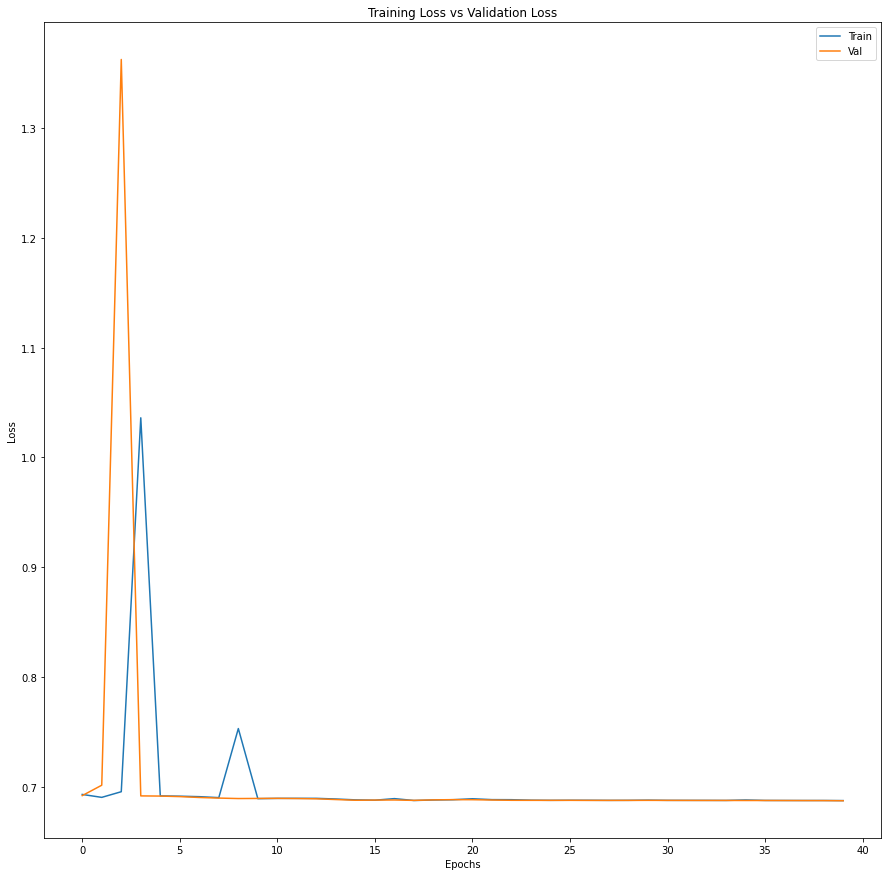

In [344]:
plt_loss(auto_encoder.history)

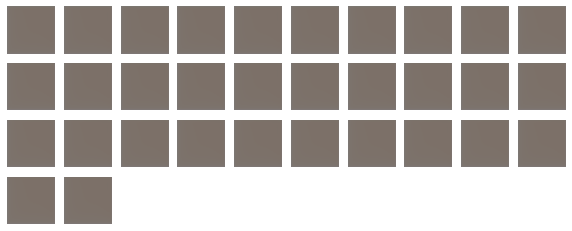

In [345]:
# pre = auto_encoder.predict(batch_generator(test_generator,10))
pre = auto_encoder.predict(samples)
draw(pre)
# draw((pre).astype('f4'))

In [157]:
pre.max()

1.2322376

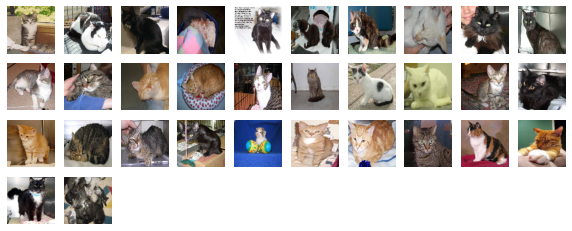

In [287]:
draw((samples).astype('f4'))

In [314]:
en = encoder.predict(train_generator)

In [315]:
a = np.array(en)
en.shape

(300, 7, 7, 512)

In [57]:
de = decoder.predict(en)
de.shape

c:\Users\201721360\Anaconda3\envs\ml\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


(301, 112, 112, 3)

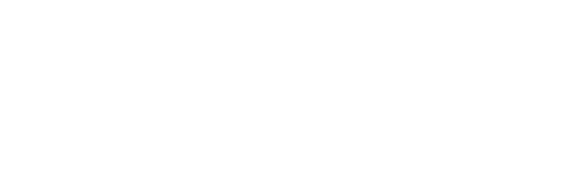

In [63]:
draw(en[:,:,:,8][:30])

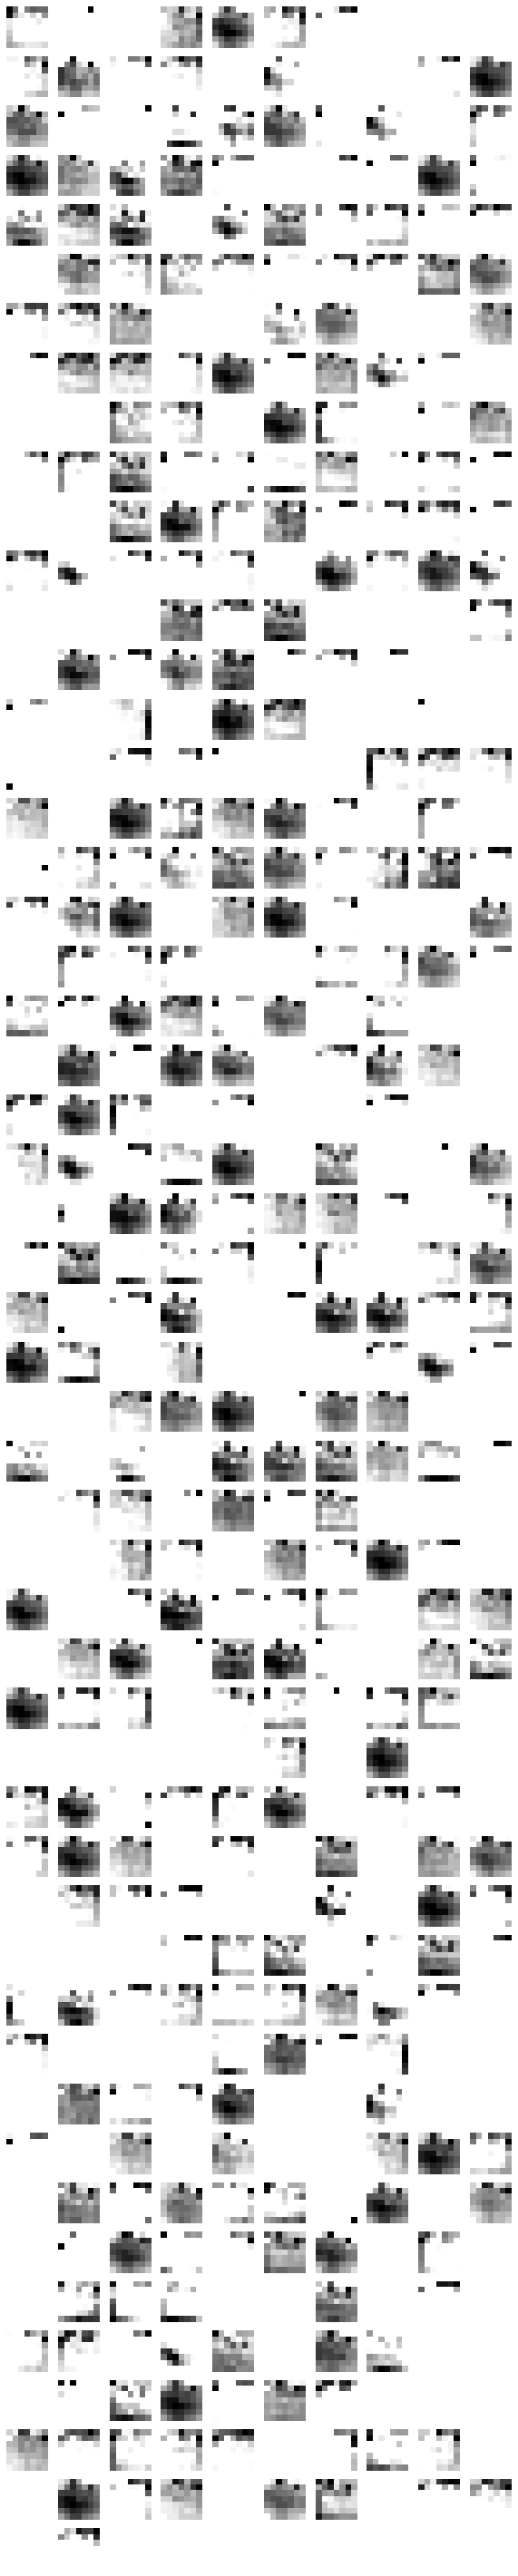

In [316]:
ens =[]
for i in range(en.shape[-1]):
    ens.append(en[0,:,:,i])
ens = np.array(ens)
ens.shape
# plt.imshow(ens[1],'gray')
draw(ens[:])

In [317]:
encoder.save('AE_f1.h5')